In [5]:
!pip install matplotlib

     |████████████████████████████████| 11.6 MB 4.9 MB/s eta 0:00:01    |███████████████████▊            | 7.1 MB 4.9 MB/s eta 0:00:01
     |████████████████████████████████| 4.6 MB 60.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 59.3 MB/s eta 0:00:01
     |████████████████████████████████| 4.5 MB 64.5 MB/s eta 0:00:01
     |████████████████████████████████| 103 kB 104.4 MB/s eta 0:00:01
     |████████████████████████████████| 310 kB 111.8 MB/s eta 0:00:01


In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

2024-03-24 05:24:09.680325: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
IMAGE_SIZE=(256,256)
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
"Dataset",
shuffle=True,
image_size=IMAGE_SIZE,
batch_size=BATCH_SIZE,
)

Found 2153 files belonging to 3 classes.


2024-03-24 05:24:16.788367: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato_healthy']

In [5]:
len(dataset)

68

In [12]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 1 1 1 0 2 0 1 1 0 2 0 1 0 0 0 1 0 2 0 1 0 0 1 0 0 1 0 0 2]


2024-03-24 05:27:22.735997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024-03-23 05:15:12.047595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


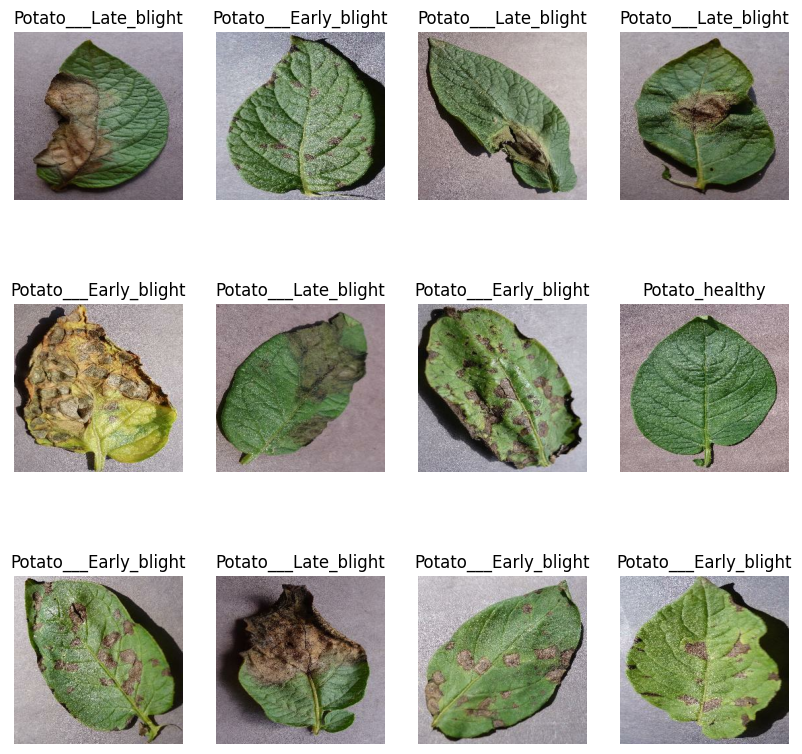

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds=dataset.take(54)
len(train_ds)

54

In [11]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [12]:
val_ds=0.1
len(dataset)*val_ds

6.800000000000001

In [13]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True,shuffle_size=1000):
    ds_size = len(ds)
    if shuffle: 
        ds=ds.shuffle (shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take (val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


In [17]:
train_ds=train_ds.cache().shuffle (1000).prefetch(buffer_size=tf.data.AUTOTUNE) 
val_ds=val_ds.cache().shuffle (1000).prefetch (buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resize_and_rescale=tf.keras.Sequential([
layers.Resizing(256,256),
layers.Rescaling(1.0/255)])

In [19]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [20]:
input_shape=(BATCH_SIZE,256,256,3)
model=models.Sequential([
resize_and_rescale,
data_augmentation,
layers.Conv2D (32, (3,3), activation='relu', input_shape = input_shape), 
layers.MaxPooling2D((2, 2)),
layers.Conv2D (64, kernel_size = (3,3), activation='relu'), 
layers.MaxPooling2D((2, 2)),
layers.Conv2D (64, kernel_size = (3,3), activation='relu'), 
layers.MaxPooling2D((2, 2)),
layers.Conv2D (64, (3, 3), activation='relu'), 
layers.MaxPooling2D((2, 2)),
layers.Conv2D (64, (3, 3), activation='relu'),
layers.MaxPooling2D((2, 2)),
layers.Conv2D (64, (3, 3), activation='relu'), 
layers.MaxPooling2D((2, 2)),
layers.Flatten(),
layers.Dense(64,activation='relu'),
layers.Dense(3,activation='softmax')
])
model.build(input_shape=input_shape)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [21]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy'])

In [23]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.4750 - loss: 0.9463 - val_accuracy: 0.6042 - val_loss: 0.8564
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.6082 - loss: 0.8019 - val_accuracy: 0.6875 - val_loss: 0.6270
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.7378 - loss: 0.5584 - val_accuracy: 0.8906 - val_loss: 0.2828
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.8335 - loss: 0.4043 - val_accuracy: 0.6562 - val_loss: 0.8654
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.7586 - loss: 0.5337 - val_accuracy: 0.8333 - val_loss: 0.3769
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.8603 - loss: 0.3011 - val_accuracy: 0.9062 - val_loss: 0.2336
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.8877 - loss: 0.2752 - val_accuracy: 0.9062 - val_loss: 0.2051
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.9519 - loss: 0.1289 - val_accuracy: 0.8073 - val_los

In [24]:
scores=model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 992ms/step - accuracy: 0.9866 - loss: 0.0427


In [25]:
scores

[0.032735034823417664, 0.98828125]

In [26]:
history

In [27]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [28]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [29]:
history.history['accuracy']

[0.4878472089767456,
 0.6423611044883728,
 0.7795138955116272,
 0.8408564925193787,
 0.8119212985038757,
 0.8640046119689941,
 0.8952546119689941,
 0.9513888955116272,
 0.9403935074806213,
 0.9652777910232544,
 0.9461805820465088,
 0.9594907164573669,
 0.9716435074806213,
 0.9716435074806213,
 0.9600694179534912,
 0.9733796119689941,
 0.9675925970077515,
 0.9745370149612427,
 0.9826388955116272,
 0.9814814925193787,
 0.9878472089767456,
 0.9832175970077515,
 0.9658564925193787,
 0.984375,
 0.9809027910232544,
 0.9878472089767456,
 0.9762731194496155,
 0.9901620149612427,
 0.9895833134651184,
 0.9664351940155029,
 0.9693287014961243,
 0.9866898059844971,
 0.9861111044883728,
 0.9913194179534912,
 0.9855324029922485,
 0.9913194179534912,
 0.9837962985038757,
 0.9890046119689941,
 0.9826388955116272,
 0.9849537014961243,
 0.9872685074806213,
 0.9907407164573669,
 0.9855324029922485,
 0.9890046119689941,
 0.9895833134651184,
 0.9901620149612427,
 0.9924768805503845,
 0.9936342835426331,
 0

In [30]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

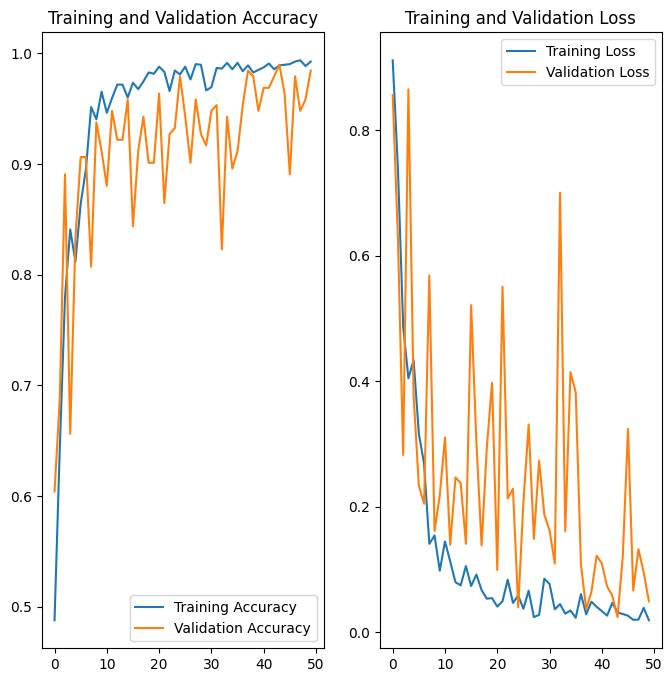

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range (EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy') 
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range (EPOCHS), loss, label='Training Loss')
plt.plot(range (EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step
predicted label: Potato___Late_blight


2024-03-23 08:02:57.499430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


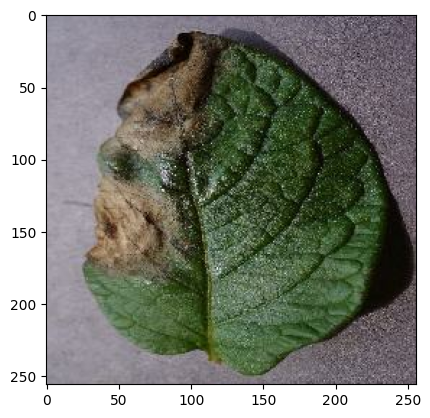

In [32]:
import numpy as np
for images_batch, labels_batch in test_ds.take (1):
    first_image=images_batch[0].numpy().astype('uint8') 
    first_label=labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names [first_label])
    batch_prediction=model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction [0])])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy()) 
    img_array = tf.expand_dims (img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions [0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


2024-03-23 08:36:17.003893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


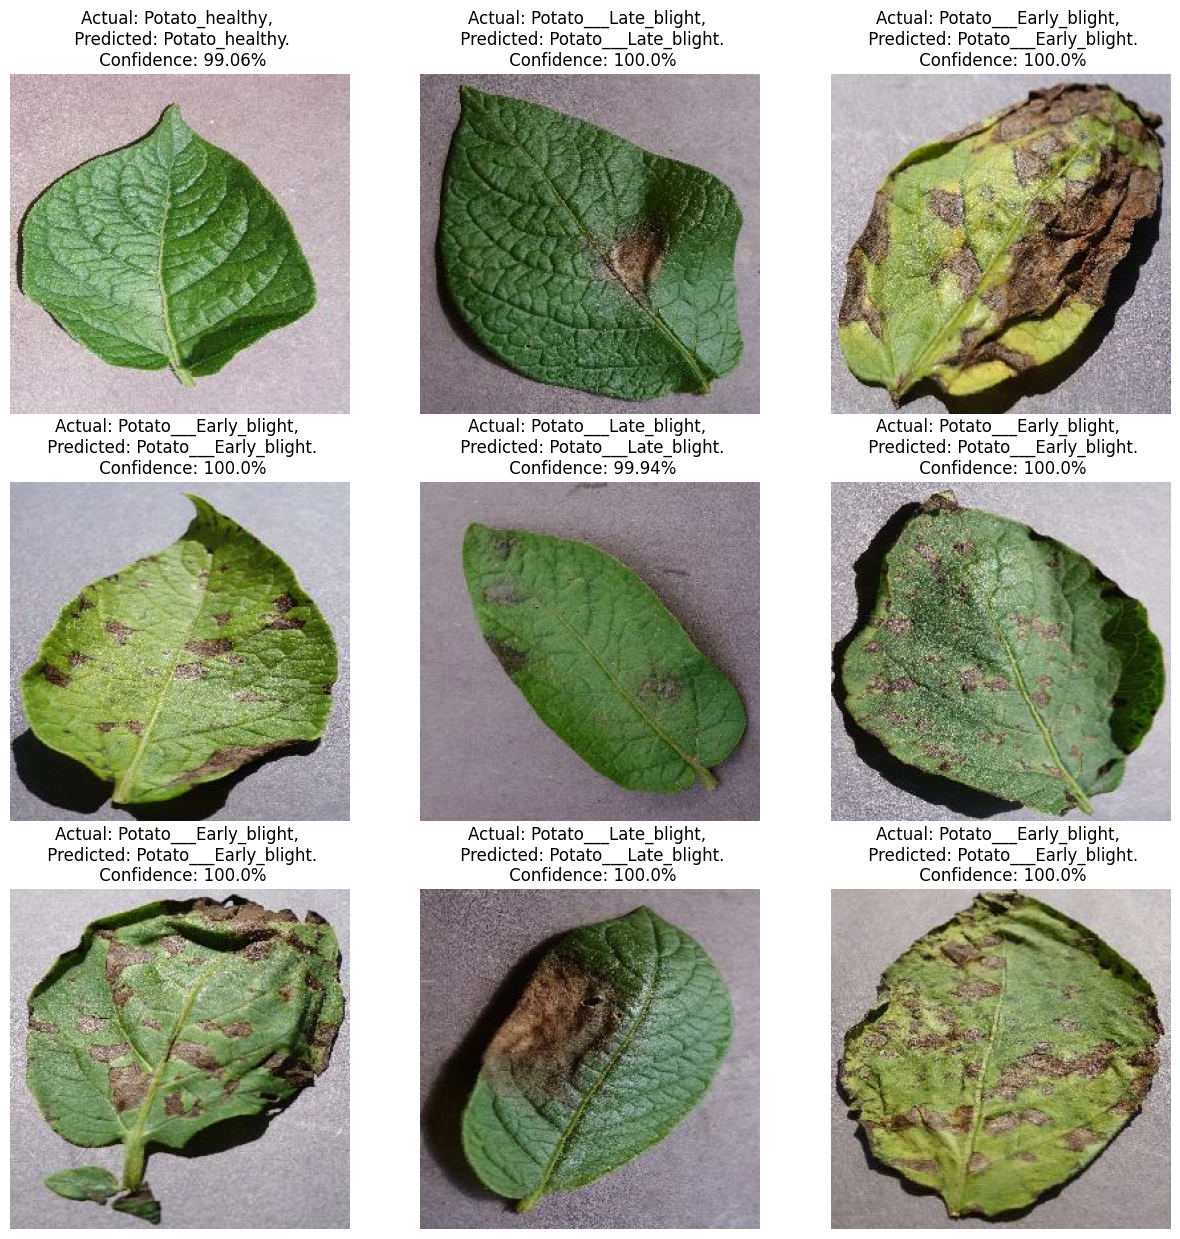

In [38]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model, images[i].numpy()) 
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [52]:
model.save('potato_disease_classification.keras')